In [1]:
import os
import subprocess
import xugrid as xu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx  
import ERA_5_analysis_support as era5
import xarray as xr
#import 
%matplotlib inline

In [46]:
base_path = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns'

model_names = ['21_25_April_2025_Base_case','21_25_April_2025_3m_surge','21_25_April_2025_dt_minus_10','21_25_April_2025_dt_plus_10']

base_name = model_names[0]
observed_names = model_names[1:]

# Paths to NetCDF history files
his_filepaths = [os.path.join(base_path, name, 'hurrywave_his.nc') for name in model_names]


# Optional: Read station names from .obs file
obs_filepath = os.path.join(base_path, model_names[0], 'hurrywave.obs')

In [47]:
def read_station_names_from_obs(file_path):
    names = []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                name = line.split('# ')[1].strip()
                names.append(name)
    return names

station_names= read_station_names_from_obs(obs_filepath)

In [48]:
print(station_names)

['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats']


In [49]:
# --- Extract data using station names ---
def extract_data(ds: xr.Dataset, station_names):
    """
    Returns nested dictionary:
    data[station_name][variable_name] = values
    """
    station_dict = {}
    for i, station_idx in enumerate(ds.stations.values):
        station_name = station_names[i]
        station_data = ds.sel(stations=station_idx)
        station_dict[station_name] = {}

        for var in ds.data_vars:
            station_dict[station_name][var] = station_data[var].values

        for coord in ds.coords:
            station_dict[station_name][coord] = station_data[coord].values

    return station_dict

# --- Master structure: data[model_name][station_name][variable_name] ---
data = {}

for model_name, file_path in zip(model_names, his_filepaths):
    ds = xr.open_dataset(file_path)
    data[model_name] = extract_data(ds, station_names)

In [55]:
print(data['21_25_April_2025_Base_case']['Euro platform'].keys())

dict_keys(['inp', 'station_id', 'station_name', 'station_x', 'station_y', 'station_z', 'crs', 'point_hm0', 'point_tp', 'point_wavdir', 'point_dirspr', 'wind_speed', 'wind_direction', 'total_runtime', 'average_dt', 'time'])


In [50]:
def plot_station_models_comparison(
    station_name,
    model_df,
    model_vars=None,
    models_to_plot=None
):
    """
    Plot time series for selected variables at a single station across multiple models.

    Parameters:
        station_name (str): Name of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
                         Structure: model_df[model][station][variable]
        model_vars (list): Variable names to include in the plot.
        models_to_plot (list): List of model names to plot. If None, plot all.
    """
    # Use first model to auto-detect variables if not provided
    example_model = next(iter(model_df))
    if model_vars is None:
        model_vars = list(model_df[example_model].get(station_name, {}).keys())

    if models_to_plot is None:
        models_to_plot = list(model_df.keys())

    n_vars = len(model_vars)

    fig = plt.figure(figsize=(14, 4 * n_vars + 5))
    fig.suptitle(f'Model Comparison at {station_name}', fontsize=16)

    # --- Map plot with station location ---
    map_ax = fig.add_axes([0.15, 0.82, 0.7, 0.16])
    m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
    m.drawcoastlines()
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    # Use lat/lon from the first model
    lat = float(model_df[example_model][station_name]["station_y"])
    lon = float(model_df[example_model][station_name]["station_x"])
    x, y = m(lon, lat)
    m.plot(x, y, 'ro', markersize=8)
    map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

    # --- Time series plots ---
    for i, var in enumerate(model_vars):
        ax = fig.add_axes([0.10, 0.60 - i * 0.22, 0.85, 0.18])
        ax.grid(True)

        for model_name in models_to_plot:
            station_data = model_df.get(model_name, {})
            if station_name in station_data and var in station_data[station_name]:
                time = station_data[station_name]["time"]
                values = station_data[station_name][var]
                ax.plot(time, values, label=model_name)

        ax.set_title(var)
        ax.set_ylabel(var)
        if i == len(model_vars) - 1:
            ax.set_xlabel("Time")
        ax.legend()

    plt.show()

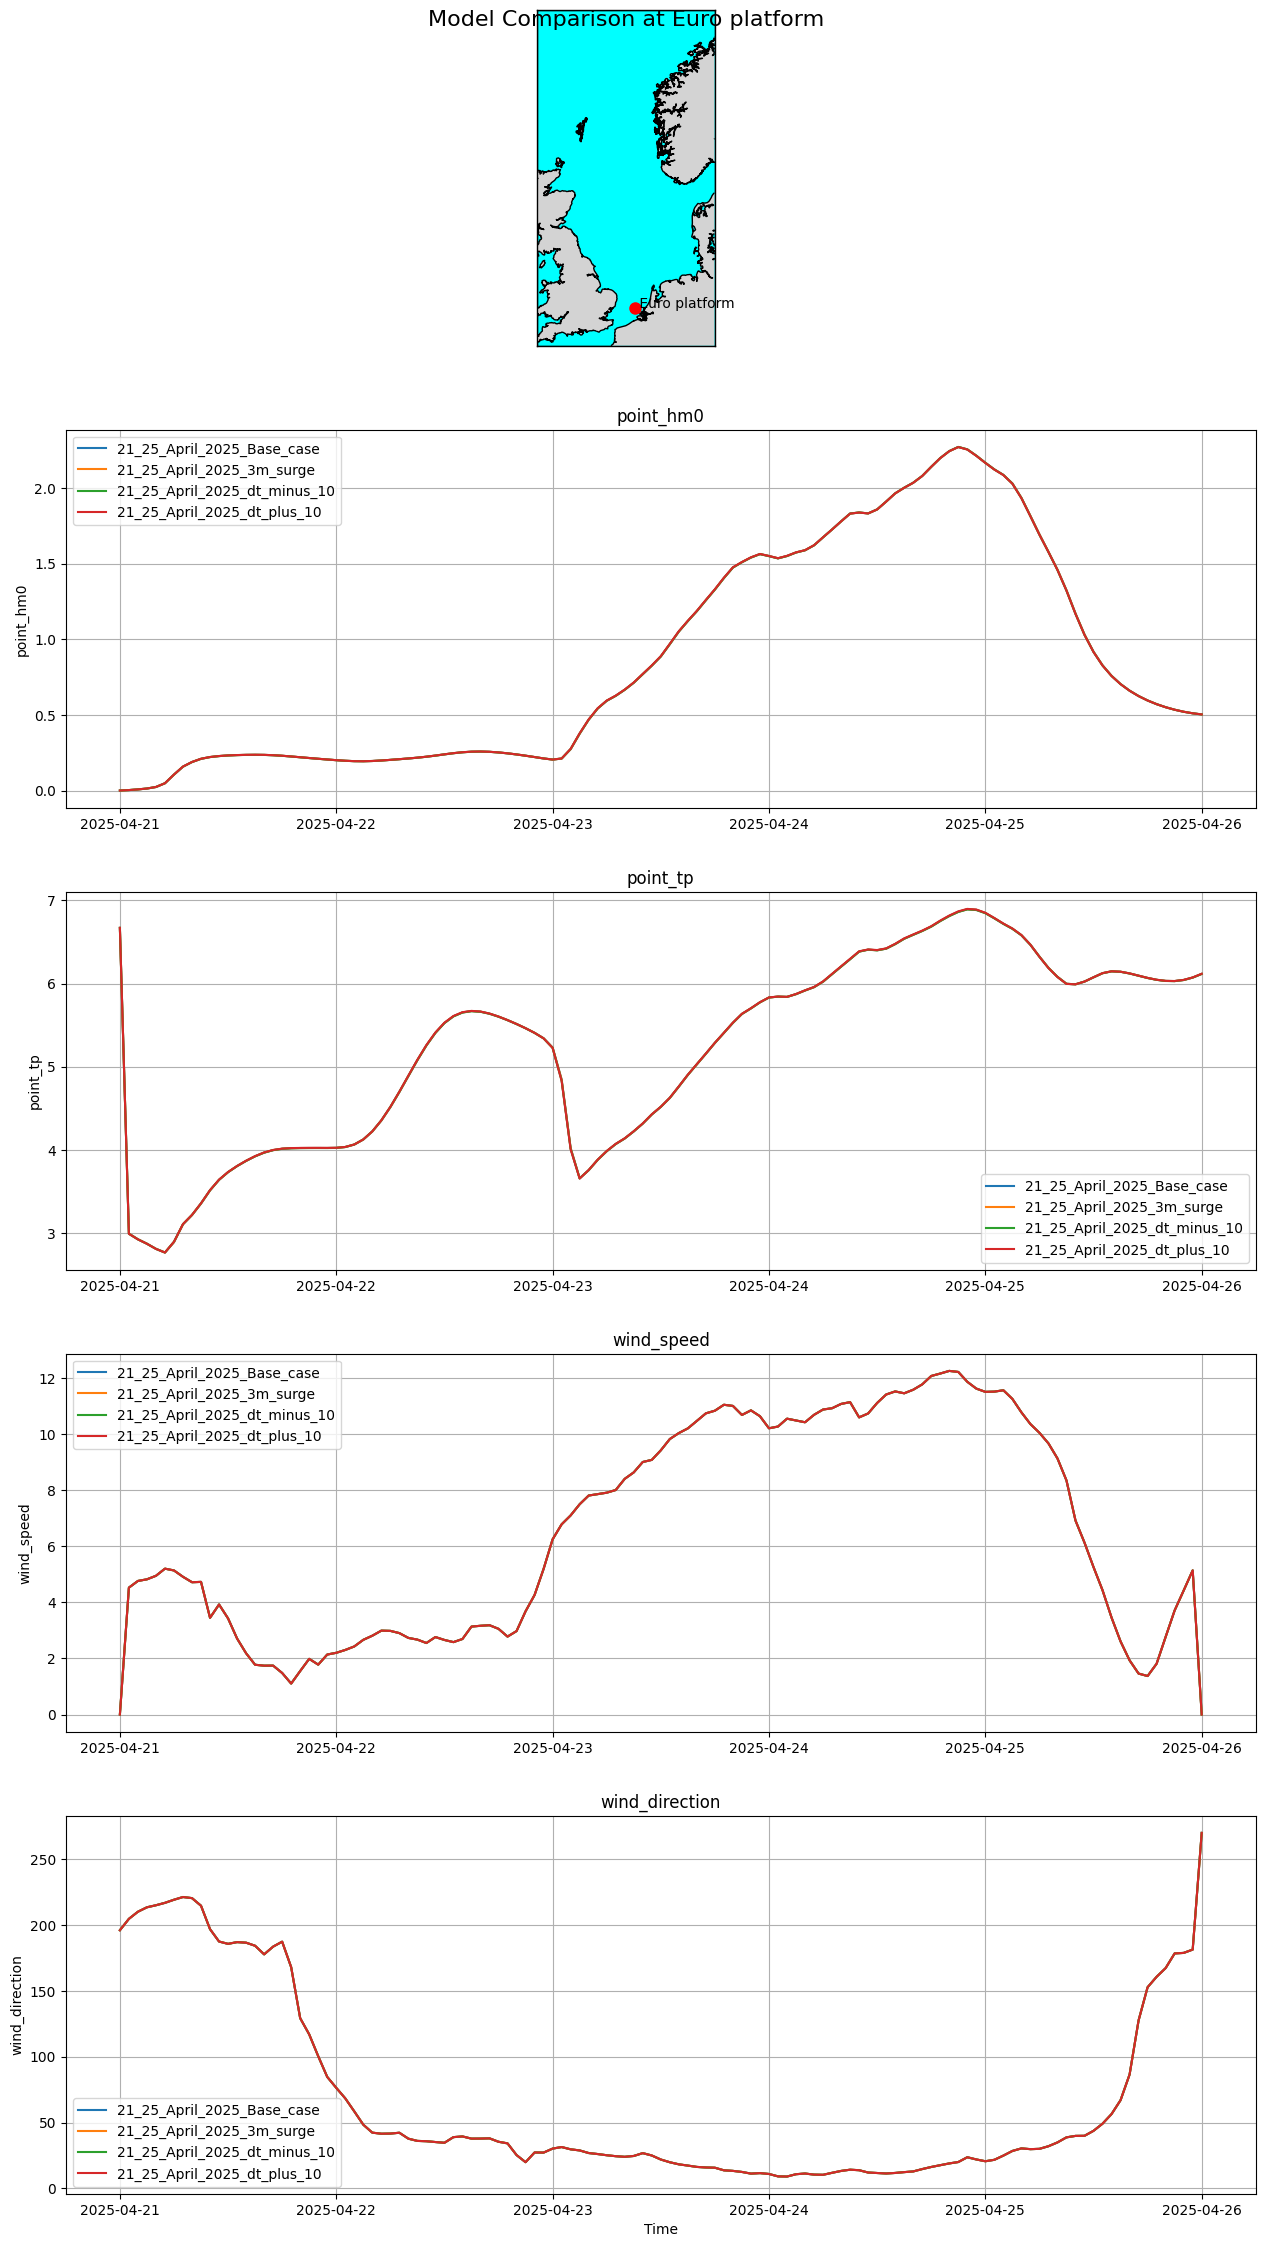

In [56]:
plot_station_models_comparison(
    station_name="Euro platform",
    model_df=data,
    model_vars=["point_hm0", "point_tp", "wind_speed", "wind_direction"],  # or leave None to plot all
    models_to_plot=model_names # or leave None to plot all
)

In [57]:
def rmse(obs, pred):
    """Root Mean Square Error"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.sqrt(np.mean((pred - obs) ** 2))

def bias(obs, pred):
    """Mean Bias (Mean Error)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.mean(pred - obs)

def scatter_index(obs, pred):
    """Scatter Index: RMSE normalized by mean of observations"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return rmse(obs, pred) / np.mean(obs)

def pinball_loss(obs, pred, quantile_pinball=0.5):
    """Pinball Loss Function for a given quantile (e.g., 0.5 for median)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    delta = obs - pred
    return np.mean(np.maximum(quantile_pinball * delta, (quantile_pinball - 1) * delta))

def pinball_loss_from_list(obs, pred, quantile_pinball_list):
    """
    Compute pinball loss for a list of quantiles.
    
    Parameters:
        obs: array-like, observed values
        pred: array-like, predicted values
        quantile_pinball_list: list of quantiles (floats between 0 and 1)
        
    Returns:
        list of pinball losses, one for each quantile
    """
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    losses = []
    for q in quantile_pinball_list:
        delta = obs - pred
        loss = np.mean(np.maximum(q * delta, (q - 1) * delta))
        losses.append(loss)
    return losses

def calculate_statistics(obs, pred,  quantile_pinball, print_stats=True):
    """Calculate RMSE, Bias, Scatter Index, and Pinball Loss for a given list of quantiles"""
    rmse_value = rmse(obs, pred) 
    bias_value = bias(obs, pred)
    scatter_index_value = scatter_index(obs, pred)
    pinball_loss_values = pinball_loss_from_list(obs, pred, quantile_pinball)

    # Print the statistics
    if print_stats:
        print(f"RMSE: {rmse_value:.4f}")
        print(f"Bias: {bias_value:.4f}")
        print(f"Scatter Index: {scatter_index_value:.4f}")
        for quantile, pinball_loss_value in zip(quantile_pinball, pinball_loss_values):
            print(f"Pinball Loss for quantile {quantile}: {pinball_loss_value:.4f}")

    return rmse_value, bias_value, scatter_index_value, pinball_loss_values

def compute_statistics_against_observations(model_dict, base_case_name, observed_case_names, quantile_pinball, variables):
    """
    Compare a base model to observed datasets using statistics, for selected variables only.

    Parameters:
    - model_dict: dict of model_name -> station -> variable -> values
    - base_case_name: str, name of the base model in model_dict
    - observed_case_names: list of str, names of observed datasets in model_dict
    - quantile_pinball: list of quantiles for pinball loss
    - variables: list of variable names to include in the analysis

    Returns:
    - df_statistics[observed_case][station][variable][statistic] = value
    """
    df_statistics = {}
    base_data = model_dict[base_case_name]

    for obs_name in observed_case_names:
        obs_data = model_dict[obs_name]
        df_statistics[obs_name] = {}

        for station in obs_data:
            if station not in base_data:
                continue  # Skip stations not present in base case
            df_statistics[obs_name][station] = {}

            for variable in variables:
                if variable not in obs_data[station] or variable not in base_data[station]:
                    continue  # Skip variables not present in both obs and base

                obs = obs_data[station][variable]
                pred = base_data[station][variable]

                rmse_val, bias_val, si_val, pinball_vals = calculate_statistics(
                    obs, pred, quantile_pinball=quantile_pinball, print_stats=False
                )

                df_statistics[obs_name][station][variable] = {
                    'RMSE': rmse_val,
                    'Bias': bias_val,
                    'Scatter Index': si_val,
                }

                for q, ploss in zip(quantile_pinball, pinball_vals):
                    df_statistics[obs_name][station][variable][f'Pinball Loss (q={q})'] = ploss

    return df_statistics

In [60]:
df_statistics = compute_statistics_against_observations(
    model_dict=data,
    base_case_name=base_name,
    observed_case_names=observed_names,
    quantile_pinball=[0.1, 0.5, 0.9],
    variables=["point_hm0", "point_tp"]
)

In [61]:
import pandas as pd
from IPython.display import display, HTML

# Prepare a table comparing statistics for each model run (columns) for all stations and variables (rows)

# Flatten df_statistics to a DataFrame
rows = []
for model_run, stations in df_statistics.items():
    for station, variables in stations.items():
        for variable, stats in variables.items():
            row = {
                'Model Run': model_run,
                'Station': station,
                'Variable': variable
            }
            row.update(stats)
            rows.append(row)

df_stats_table = pd.DataFrame(rows)

# Pivot the table: rows = (Station, Variable, Statistic), columns = Model Run
df_stats_long = df_stats_table.melt(
    id_vars=['Model Run', 'Station', 'Variable'],
    var_name='Statistic',
    value_name='Value'
)

df_stats_pivot = df_stats_long.pivot_table(
    index=['Station', 'Variable', 'Statistic'],
    columns='Model Run',
    values='Value'
)

# Display the table as a scrollable DataFrame

display(HTML(df_stats_pivot.to_html(max_rows=100, max_cols=10, notebook=True, border=1)))

In [ ]:
# plot wave height - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['Hm0'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 vmin = 0, vmax = 10,
                 cbar_kwargs={'label': 'Hs [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Significant wave height', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]') 
